In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import datasets
import glob
import time
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
def color_hist(img, channel = 'ALL', n_bins = 32, range_bins = (0, 256), bin_centers_return = False):
    
    rhist = np.histogram(img[:, :, 0], bins = n_bins, range = range_bins)
    ghist = np.histogram(img[:, :, 1], bins = n_bins, range = range_bins)
    bhist = np.histogram(img[:, :, 2], bins = n_bins, range = range_bins)
    
    bin_edges = rhist[1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
    if channel == '0':
        hist_features = rhist[0]
    elif channel == '1':
        hist_features = ghist[0]
    elif channel ==  '2':
        hist_features = bhist[0]
    elif channel == 'ALL':
        hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
        bin_centers = np.concatenate((bin_centers, bin_centers, bin_centers))
        
    if bin_centers_return == True:
        return hist_features, bin_centers
    else:
        return hist_features

In [3]:
def bin_spatial(img, color_space = 'RGB', size = (32, 32)):

    feature_image = img
    features = cv2.resize(feature_image, size)
    features = features.ravel()
    
    return features

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):

    # SINGLE CHANNEL INPUT EXPECTED
    
    # Orientations: Typical values are between 6 and 12 bins. 
    
    if vis == True:
        features, hog_img = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),
                            visualise=vis,  feature_vector=feature_vec) #, block_norm = 'L2-Hys')
        return features, hog_img
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),
                            visualise=vis,  feature_vector=feature_vec) #, block_norm = 'L2-Hys')
        return features

In [5]:
def cvt_color(img, color_space):
    
    # ASSUMING BGR INPUT
    
    if color_space == 'RGB':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    return feature_image

In [6]:
def draw_boxes(img, bboxes, color = (0, 0, 255), thick = 6):
    
    copy = np.copy(img)
    
    for bbox in bboxes:
        cv2.rectangle(copy, bbox[0], bbox[1], color, thick)
        
    return copy

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        

    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    x_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    y_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    x_buffer = np.int(xy_window[0] * xy_overlap[0])
    y_buffer = np.int(xy_window[1] * xy_overlap[1])
    nx_windows = np.int((xspan - x_buffer) / x_step)
    ny_windows = np.int((yspan - y_buffer) / y_step)
    
    window_list = []
    
    for row in range(ny_windows):
        for column in range(nx_windows):
            start_x = (column * x_step) + x_start_stop[0]
            end_x = start_x + xy_window[0]
            start_y = (row * y_step) + y_start_stop[0]
            end_y = start_y + xy_window[1]

            pt1 = (start_x, start_y)
            pt2 = (end_x, end_y)
            window_list.append((pt1, pt2))
            
    return window_list

In [8]:
# This one is for the training data
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    features_list = []
    
    for img in imgs:
        
        image_features = []
        
        feature_image = cvt_color(cv2.imread(img), color_space)
        
        if spatial_feat == True:
            image_features.append(bin_spatial(feature_image, color_space, spatial_size))
            
        if hist_feat == True:
            image_features.append(color_hist(feature_image, channel = 'ALL', n_bins = hist_bins,
                                       range_bins = (0, 256), bin_centers_return = False))
            
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
                    
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel],
                                                         orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            image_features.append(hog_features)
            
        features_list.append(np.concatenate(image_features))
    
    return features_list

In [9]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):



    image_features = []
    

    feature_image = cvt_color(img, color_space)

    if spatial_feat == True:
        image_features.append(bin_spatial(feature_image, color_space, spatial_size))

    if hist_feat == True:
        image_features.append(color_hist(feature_image, channel = 'ALL', n_bins = hist_bins,
                                   range_bins = (0, 256), bin_centers_return = False))

    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))

            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel],
                                                     orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        image_features.append(hog_features)
        
    return np.concatenate(image_features)

In [10]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    on_windows = []
    
    for window in windows:
        x_start = window[0][0]
        x_end = window[1][0]
        y_start = window[0][1]
        y_end = window[1][1]
        
        sample_image = cv2.resize(img[y_start:y_end, x_start:x_end], (64, 64)) ####################### Not understood
        
        sample_features = single_img_features(sample_image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        
        sample_features_scaled = scaler.transform(np.array(sample_features).reshape(1, -1)) #################### Not understood
        
        prediction = clf.predict(sample_features_scaled)
        
        if prediction == 1:
            on_windows.append(window)
    
    return on_windows

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [ ]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    # img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cvt_color(img_tosearch, 'YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                     (np.int(imshape[1]/scale),
                                      np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[] #https://github.com/preritj/Vechicle-Detection-Tracking
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, channel = 'ALL', n_bins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,
                                                          hist_features,
                                                          hog_features)).reshape(1, -1))  
            
            # Scale features and make a prediction  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (255,0,0),8)
                bbox_list.append(((xbox_left, ytop_draw+ystart), #github.com/preritj
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    
    return bbox_list

In [ ]:
car_imgs = glob.glob('New Folder/vehicles/*/*.png')
notcar_imgs = glob.glob('New Folder/non-vehicles/*/*.png')

cars = []
notcars = []

for car_img in car_imgs:
    cars.append(car_img)
for notcar_img in notcar_imgs:
    notcars.append(notcar_img)

In [ ]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL'# Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()


cars_features = extract_features(cars, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)

notcars_features = extract_features(notcars, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)

X = np.vstack((cars_features, notcars_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
X_scaled = X_scaler.transform(X)

y = np.hstack((np.ones(len(cars_features)), np.zeros(len(notcars_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .2, shuffle = True, random_state = rand_state)


clf = svm.LinearSVC()
# parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 2, 5, 10, 20]}
# clf_2_tuned = GridSearchCV(estimator = clf_2, param_grid = parameters)
t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()

print('Time of training with GridSearchCV parameters tuning: ', round(t2-t1, 3), ' seconds')
print('')
print('SVM classifier accuracy is: ', round(clf.score(X_test, y_test), 3))
print('')
# print('SVM best parameters are: ', clf_2_tuned.best_params_)
# print('')

In [ ]:
image = cv2.imread('test_images/test3.jpg')
draw_image = cvt_color(image, 'RGB')


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.7))

hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
                       
heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat, hot_windows)
heat = apply_threshold(heat, 1)
# heatmap = np.clip(heat, 0, 255)
labels = label(heat)

# Read in the last image above
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
fig = plt.figure(figsize=(24, 24)) 
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heat, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

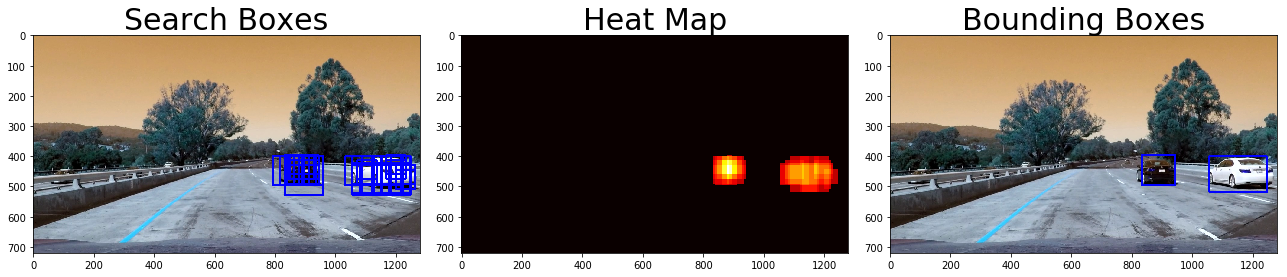

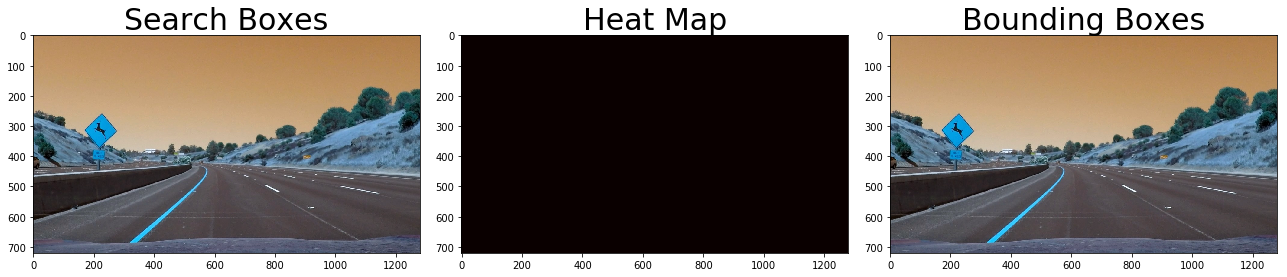

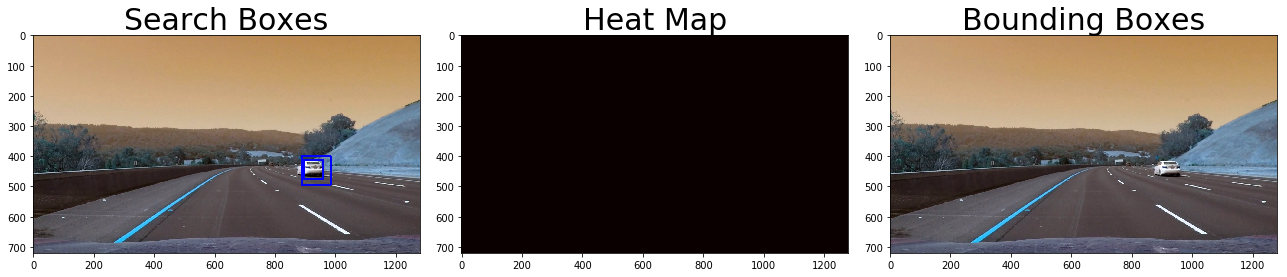

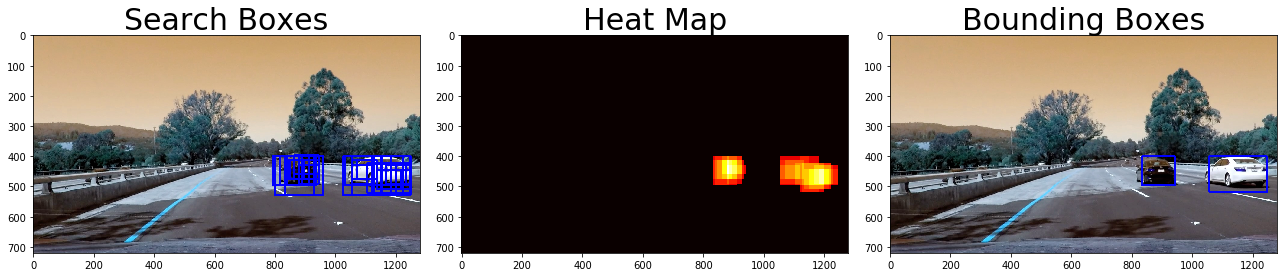

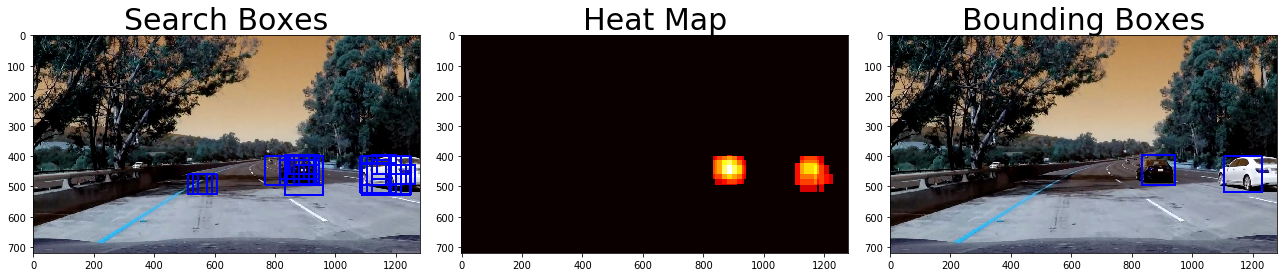

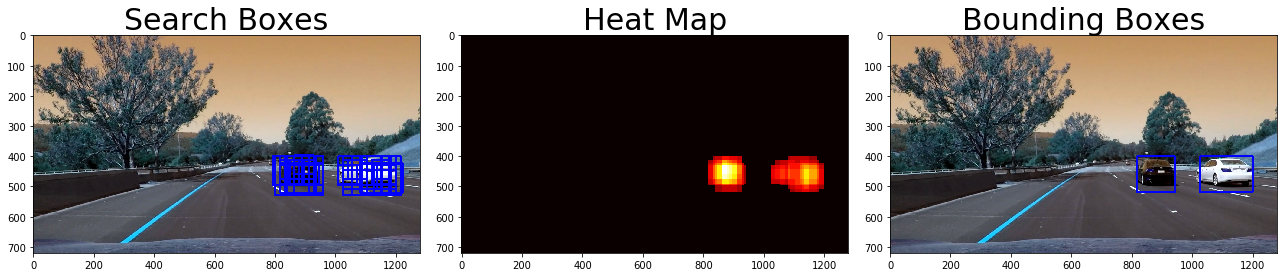

In [ ]:
svc = clf
for i in range(1,7):
    
    fname = 'test_images/test{}.jpg'.format(i)
    img = cv2.imread(fname)
    

    orient=9
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
   
    # Copied from 'jeremy-shannon'
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    out_img = draw_boxes(img, bbox_list)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 3)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(out_img)
    ax1.set_title('Search Boxes', fontsize=30)
    ax2.imshow(heat, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)
    ax3.imshow(new_img)
    ax3.set_title('Bounding Boxes', fontsize=30)
    #plt.savefig('output_images/heat_map1.png', bbox_inches="tight")

In [ ]:

def process_image(img):

    orient=9
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 3)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return new_img

In [ ]:
test_output = "project_output.mp4"
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [26:07<00:01,  1.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 26min 9s
